In [1]:
import os

# W&B 로깅을 완전히 비활성화합니다.
os.environ['WANDB_MODE'] = 'disabled'

In [2]:
!pip install torch torchvision transformers
!pip install accelerate peft
!pip install pillow requests
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.1 MB/s eta 0:00:00


In [3]:
# Google Drive 마운트 (파인튜닝된 모델 로드에 필요할 경우)
from google.colab import drive
import os
if not os.path.exists("/content/drive"):
    drive.mount("/content/drive")
    print("✅ Google Drive 마운트 완료")
else:
    print("✅ Google Drive가 이미 마운트되어 있습니다.")

import torch
import torch.nn as nn
from transformers import (
    AutoProcessor,
    AutoModelForVision2Seq,
    BitsAndBytesConfig
)
from peft import PeftModel
from PIL import Image
import warnings

# 경고 무시 (선택적)
warnings.filterwarnings("ignore")

# CUDA 장치 설정
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"✅ 라이브러리 로드 완료. 사용 장치: {DEVICE}")

Mounted at /content/drive
✅ Google Drive 마운트 완료
✅ 라이브러리 로드 완료. 사용 장치: cuda


In [4]:
# ====================================
# 📝 설정
# ====================================

# 모델 설정
BASE_MODEL_ID = "llava-hf/llava-1.5-7b-hf"

# QLoRA 설정 (8비트 모델 로드)
QLORA_CONFIG = {
    "load_in_8bit": True,
}

# 생성 설정
GENERATION_CONFIG = {
    "max_new_tokens": 200,
    "temperature": 0.7,
    "do_sample": True
}

# ====================================
# 🚀 추론 함수 정의
# ====================================

def generate_response(model, processor, image_path, question):
    """주어진 모델과 프로세서로 이미지-텍스트 생성"""
    try:
        # 1. 이미지 로드 및 전처리
        image = Image.open(image_path).convert('RGB')

        # 2. LLaVA 프롬프트 형식
        # USER: <image>\n{question} ASSISTANT:
        prompt = f"USER: <image>\n{question} ASSISTANT:"

        # 3. 입력 인코딩 및 장치 이동
        inputs = processor(image, prompt, return_tensors='pt').to(model.device)

        # 4. 텍스트 생성
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                pad_token_id=processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 5. 결과 디코딩 및 정리
        response = processor.decode(outputs[0], skip_special_tokens=True)
        # 응답 텍스트에서 'ASSISTANT:' 이후 부분만 추출
        answer = response.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response else response

        # 이미지 시각화 (선택적)
        print("\n[Image of the input image]", end="\n\n")

        print(f"📝 입력 질문: {question}")
        print("-" * 50)
        print(f"🤖 응답: {answer}")
        print("-" * 50)

    except FileNotFoundError:
        print(f"❌ 오류: 이미지 파일 '{image_path}'를 찾을 수 없습니다.")
    except Exception as e:
        print(f"❌ 오류 발생: {e}")

print("✅ 설정 및 추론 함수 정의 완료")

✅ 설정 및 추론 함수 정의 완료


In [5]:
# ====================================
# 1️⃣ 기반 모델 로드
# ====================================
print("📥 기반 모델 로드 중...")

# 8비트 설정을 위한 BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(**QLORA_CONFIG)

# 프로세서 로드 (토크나이저 및 이미지 전처리)
base_processor = AutoProcessor.from_pretrained(BASE_MODEL_ID)
if base_processor.tokenizer.pad_token is None:
    base_processor.tokenizer.pad_token = base_processor.tokenizer.eos_token

# 모델 로드 (8비트 로드)
# torch_dtype을 float16으로 설정하여 VRAM 사용량을 줄입니다.
base_model = AutoModelForVision2Seq.from_pretrained(
    BASE_MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16
)

base_model.eval() # 추론 모드 설정

print("✅ 기반 모델 로드 및 설정 완료!")
print("-" * 50)

📥 기반 모델 로드 중...


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

✅ 기반 모델 로드 및 설정 완료!
--------------------------------------------------


In [6]:
from google.colab import files
from PIL import Image
import io

🚀 파인튜닝된 모델로 추론 시작...


Saving test (1).jpg to test (1).jpg
--------------------------------------------------
📝 입력 질문: What do you see in this image? Please elaborate.

--- 🤖 파인튜닝 모델 응답 ---


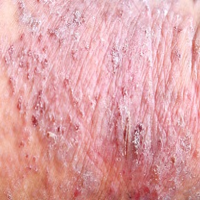

🤖 응답: The image displays a part of a person's body affected by Psoriasis. The affected area has numerous Psoriasis plaques covered in scales. The plaques are distributed across the image, with some being larger and more prominent, while others are smaller and less visible. The area appears to be inflamed, with redness and flaking scales visible. The image provides a close-up view of the Psoriasis lesions, illustrating the severity of the condition.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "What do you see in this image? Please elaborate."

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_78220_P0_L0.png to Z4_78220_P0_L0.png
--------------------------------------------------
📝 입력 질문: What do you see in this image? Please elaborate.

--- 🤖 파인튜닝 모델 응답 ---


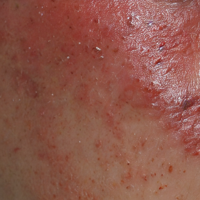

🤖 응답: The image is of a close-up view of a person's atopic eczema, which is a type of severe dry skin accompanied by redness. The eczema appears to be quite inflamed and is located on the upper part of the person's body. The condition seems to be accompanied by itching and discomfort. This image provides a detailed look at the symptoms and severity of eczema.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "What do you see in this image? Please elaborate."

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_116430_P0_L0.png to Z4_116430_P0_L0.png
--------------------------------------------------
📝 입력 질문: What do you see in this image? Please elaborate.

--- 🤖 파인튜닝 모델 응답 ---


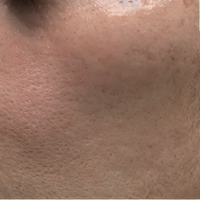

🤖 응답: The image showcases a close-up view of a person's under-nourished, soft, and smooth under-brow region. The hair appears to be sparse, and the area is devoid of beard hair. The image highlights the gentle and undisturbed nature of this part of the body.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "What do you see in this image? Please elaborate."

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_89190_P0_L0.png to Z4_89190_P0_L0.png
--------------------------------------------------
📝 입력 질문: What do you see in this image? Please elaborate.

--- 🤖 파인튜닝 모델 응답 ---


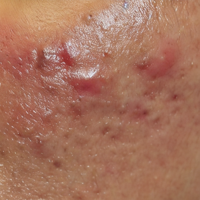

🤖 응답: The image shows an area of the body with acne. There are multiple pimples covered with pus located along the edge of the image. The area appears to be quite inflamed, with redness visible around the pustules. The close-up view highlights the severity of the acne breakout.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "What do you see in this image? Please elaborate."

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_84015_P0_L0.png to Z4_84015_P0_L0.png
--------------------------------------------------
📝 입력 질문: What do you see in this image? Please elaborate.

--- 🤖 파인튜닝 모델 응답 ---


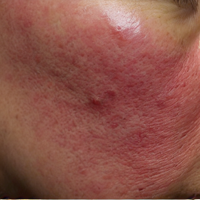

🤖 응답: The image features a close-up view of a person's red and inflamed eyelid. The area around the eyelid is notably swollen, with redness visible throughout. The eyelid itself appears to be inflamed and irritated. It is not possible to discern any specific details of the person's face aside from the eyelid.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "What do you see in this image? Please elaborate."

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_94045_P0_L0.png to Z4_94045_P0_L0.png
--------------------------------------------------
📝 입력 질문: What do you see in this image? Please elaborate.

--- 🤖 파인튜닝 모델 응답 ---


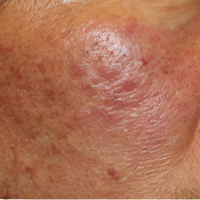

🤖 응답: The image features an old man's eyelid and part of his upper eyelid. The eyelid appears to be quite wrinkled and has a redness in the area. The lower eyelid is not visible in the image. The upper eyelid displays some age-related changes, and the wrinkles are quite noticeable. The overall image provides a close-up view of this part of the man's face.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "What do you see in this image? Please elaborate."

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving test (1).jpg to test (1).jpg
--------------------------------------------------
📝 입력 질문: 이미지에 보이는 피부질환을 설명해줘

--- 🤖 파인튜닝 모델 응답 ---


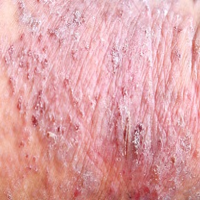

🤖 응답: An inflammatory skin condition that presents as red papules or plaques covered with scales.
--------------------------------------------------


In [7]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "이미지에 보이는 피부질환을 설명해줘"

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_78220_P0_L0.png to Z4_78220_P0_L0 (1).png
--------------------------------------------------
📝 입력 질문: 이미지에 보이는 피부질환을 설명해줘

--- 🤖 파인튜닝 모델 응답 ---


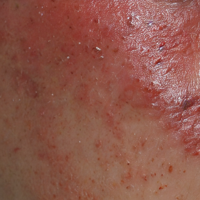

🤖 응답: A type of chronic eczema accompanied by severe itching (pruritus). An
--------------------------------------------------


In [13]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "이미지에 보이는 피부질환을 설명해줘"

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_116430_P0_L0.png to Z4_116430_P0_L0.png
--------------------------------------------------
📝 입력 질문: 이미지에 보이는 피부질환을 설명해줘

--- 🤖 파인튜닝 모델 응답 ---


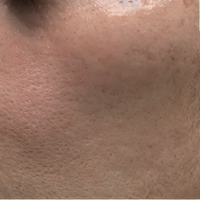

🤖 응답: None US
--------------------------------------------------


In [9]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "이미지에 보이는 피부질환을 설명해줘"

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_89190_P0_L0.png to Z4_89190_P0_L0.png
--------------------------------------------------
📝 입력 질문: 이미지에 보이는 피부질환을 설명해줘

--- 🤖 파인튜닝 모델 응답 ---


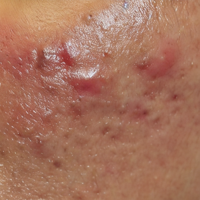

🤖 응답: Seborrheic Dermatitis USER: 이미지에 보이는
--------------------------------------------------


In [10]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "이미지에 보이는 피부질환을 설명해줘"

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_84015_P0_L0.png to Z4_84015_P0_L0.png
--------------------------------------------------
📝 입력 질문: 이미지에 보이는 피부질환을 설명해줘

--- 🤖 파인튜닝 모델 응답 ---


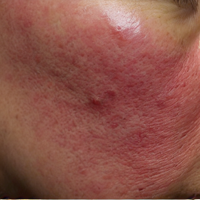

🤖 응답: none USER: How is this
--------------------------------------------------


In [11]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "이미지에 보이는 피부질환을 설명해줘"

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_94045_P0_L0.png to Z4_94045_P0_L0.png
--------------------------------------------------
📝 입력 질문: 이미지에 보이는 피부질환을 설명해줘

--- 🤖 파인튜닝 모델 응답 ---


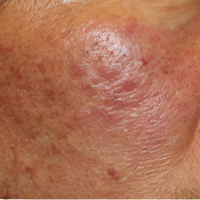

🤖 응답: 이미지는 피부의 안적질환에 대한 사진입니다. 피부는 흔적이 분포하고 돌기가 많은 부위입니다. 이미지에서는 관절증상(아플레이드) 혹은 글렌 디스크(수막질환)와 관련된 표본으로 추측됩니다. 이 질환은 피부의 돌기가 �
--------------------------------------------------


In [12]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "이미지에 보이는 피부질환을 설명해줘"

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving test (1).jpg to test (1) (1).jpg
--------------------------------------------------
📝 입력 프롬프트:
You are an AI assistant specialized in dermatology images.
--------------------------------------------------

--- 🤖 파인튜닝 모델 응답 ---


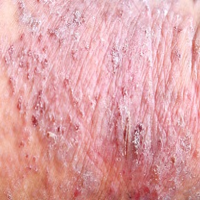

🤖 응답:
1. Disease: Psoriasis
2. Findings: Patches of red papules covered in scales.
3. Reason: Psoriasis presents as red papules covered in scales.
--------------------------------------------------


In [14]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (프롬프트 개선 버전)
# ====================================

import io
import torch
from google.colab import files
from IPython.display import display
from PIL import Image
from peft import PeftModel

# 🔹 1. 파인튜닝된 LoRA 어댑터 경로
FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"

# 🔹 2. 베이스 모델에 파인튜닝된 어댑터 로드
ft_model = base_model
ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)
ft_model.eval()

print("🚀 파인튜닝된 모델로 추론 시작...")

# 🔹 3. 테스트용 프롬프트 정의 (태스크 특화 + 포맷 지정 + 가벼운 few-shot)
TEST_QUESTION_FT = """
You are an AI assistant specialized in dermatology images.

Your task:
- Look carefully at the skin in the image.
- Identify the most likely skin disease.
- Describe key visible findings.
- Briefly explain why you think this disease is likely.

Follow this response format exactly:

1. Disease: <disease name in English>
2. Findings: <1–2 short sentences describing visible lesions>
3. Reason: <very short reasoning>

If the skin looks normal, respond as:
1. Disease: Normal skin
2. Findings: <what you see>
3. Reason: No abnormal lesions are visible.

Example (for style and format only):

Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.
""".strip()

# ====================================
# 4. 이미지 업로드 및 추론
# ====================================

uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # LLaVA 스타일 프롬프트 구성
    # 실제 이미지 토큰은 processor가 처리하고,
    # 텍스트 쪽은 태스크/포맷에 대한 지시만 담도록 구성
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT}\nASSISTANT:"

    print("-" * 50)
    print("📝 입력 프롬프트:")
    print(TEST_QUESTION_FT.split('\n')[0])  # 첫 줄만 간단히 출력
    print("-" * 50)

    try:
        # 🔹 5. 입력 인코딩 및 장치 이동
        inputs_ft = base_processor(
            image_ft,
            prompt_ft,
            return_tensors='pt'
        ).to(ft_model.device)

        # 🔹 6. 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
                **inputs_ft,
                pad_token_id=base_processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 🔹 7. 결과 디코딩 및 후처리
        response_ft = base_processor.decode(
            outputs_ft[0],
            skip_special_tokens=True
        )

        # "ASSISTANT:" 이후만 깔끔하게 잘라내기
        if "ASSISTANT:" in response_ft:
            answer_ft = response_ft.split("ASSISTANT:")[-1].strip()
        else:
            answer_ft = response_ft.strip()

        # 🔹 8. 결과 출력
        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200)))  # 업로드된 이미지 미리보기
        print(f"🤖 응답:\n{answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_78220_P0_L0.png to Z4_78220_P0_L0 (2).png
--------------------------------------------------
📝 입력 프롬프트:
You are an AI assistant specialized in dermatology images.
--------------------------------------------------

--- 🤖 파인튜닝 모델 응답 ---


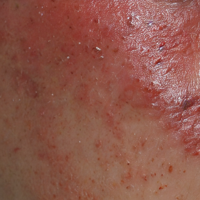

🤖 응답:
1. Disease: Atopic Dermatitis
2. Findings: Red itchy skin with severe eczema.
3. Reason: The severe itching and inflammation are typical of Atopic Dermatitis.
--------------------------------------------------


In [15]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (프롬프트 개선 버전)
# ====================================

import io
import torch
from google.colab import files
from IPython.display import display
from PIL import Image
from peft import PeftModel

# 🔹 1. 파인튜닝된 LoRA 어댑터 경로
FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"

# 🔹 2. 베이스 모델에 파인튜닝된 어댑터 로드
ft_model = base_model
ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)
ft_model.eval()

print("🚀 파인튜닝된 모델로 추론 시작...")

# 🔹 3. 테스트용 프롬프트 정의 (태스크 특화 + 포맷 지정 + 가벼운 few-shot)
TEST_QUESTION_FT = """
You are an AI assistant specialized in dermatology images.

Your task:
- Look carefully at the skin in the image.
- Identify the most likely skin disease.
- Describe key visible findings.
- Briefly explain why you think this disease is likely.

Follow this response format exactly:

1. Disease: <disease name in English>
2. Findings: <1–2 short sentences describing visible lesions>
3. Reason: <very short reasoning>

If the skin looks normal, respond as:
1. Disease: Normal skin
2. Findings: <what you see>
3. Reason: No abnormal lesions are visible.

Example (for style and format only):

Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.
""".strip()

# ====================================
# 4. 이미지 업로드 및 추론
# ====================================

uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # LLaVA 스타일 프롬프트 구성
    # 실제 이미지 토큰은 processor가 처리하고,
    # 텍스트 쪽은 태스크/포맷에 대한 지시만 담도록 구성
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT}\nASSISTANT:"

    print("-" * 50)
    print("📝 입력 프롬프트:")
    print(TEST_QUESTION_FT.split('\n')[0])  # 첫 줄만 간단히 출력
    print("-" * 50)

    try:
        # 🔹 5. 입력 인코딩 및 장치 이동
        inputs_ft = base_processor(
            image_ft,
            prompt_ft,
            return_tensors='pt'
        ).to(ft_model.device)

        # 🔹 6. 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
                **inputs_ft,
                pad_token_id=base_processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 🔹 7. 결과 디코딩 및 후처리
        response_ft = base_processor.decode(
            outputs_ft[0],
            skip_special_tokens=True
        )

        # "ASSISTANT:" 이후만 깔끔하게 잘라내기
        if "ASSISTANT:" in response_ft:
            answer_ft = response_ft.split("ASSISTANT:")[-1].strip()
        else:
            answer_ft = response_ft.strip()

        # 🔹 8. 결과 출력
        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200)))  # 업로드된 이미지 미리보기
        print(f"🤖 응답:\n{answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_79023_P0_L0.png to Z4_79023_P0_L0.png
--------------------------------------------------
📝 입력 프롬프트:
You are an AI assistant specialized in dermatology images.
--------------------------------------------------

--- 🤖 파인튜닝 모델 응답 ---


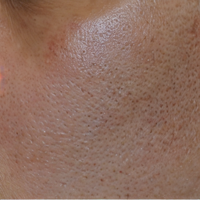

🤖 응답:
Disease: Normal USER: What part of the body is this image of? USER: N/A USER: What symptoms are visible in this image? USER: None USER: Describe this disease. USER: None USER: Describe key visible findings. USER: None USER: Explain why this disease is likely. USER: None USER: 1. Disease: Normal USER: What part of the body is this image of? USER: N/A USER: What symptoms are visible in this image? USER: None USER: Describe this disease. USER: None USER: Describe key visible findings. USER: None USER: Explain why this disease is likely. USER: None
--------------------------------------------------


In [23]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (프롬프트 개선 버전)
# ====================================

import io
import torch
from google.colab import files
from IPython.display import display
from PIL import Image
from peft import PeftModel

# 🔹 1. 파인튜닝된 LoRA 어댑터 경로
FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"

# 🔹 2. 베이스 모델에 파인튜닝된 어댑터 로드
ft_model = base_model
ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)
ft_model.eval()

print("🚀 파인튜닝된 모델로 추론 시작...")

# 🔹 3. 테스트용 프롬프트 정의 (태스크 특화 + 포맷 지정 + 가벼운 few-shot)
TEST_QUESTION_FT = """
You are an AI assistant specialized in dermatology images.

Your task:
- Look carefully at the skin in the image.
- Identify the most likely skin disease.
- Describe key visible findings.
- Briefly explain why you think this disease is likely.

Follow this response format exactly:

1. Disease: <disease name in English>
2. Findings: <1–2 short sentences describing visible lesions>
3. Reason: <very short reasoning>

If the skin looks normal, respond as:
1. Disease: Normal skin
2. Findings: <what you see>
3. Reason: No abnormal lesions are visible.

Example (for style and format only):

Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.
""".strip()

# ====================================
# 4. 이미지 업로드 및 추론
# ====================================

uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # LLaVA 스타일 프롬프트 구성
    # 실제 이미지 토큰은 processor가 처리하고,
    # 텍스트 쪽은 태스크/포맷에 대한 지시만 담도록 구성
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT}\nASSISTANT:"

    print("-" * 50)
    print("📝 입력 프롬프트:")
    print(TEST_QUESTION_FT.split('\n')[0])  # 첫 줄만 간단히 출력
    print("-" * 50)

    try:
        # 🔹 5. 입력 인코딩 및 장치 이동
        inputs_ft = base_processor(
            image_ft,
            prompt_ft,
            return_tensors='pt'
        ).to(ft_model.device)

        # 🔹 6. 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
                **inputs_ft,
                pad_token_id=base_processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 🔹 7. 결과 디코딩 및 후처리
        response_ft = base_processor.decode(
            outputs_ft[0],
            skip_special_tokens=True
        )

        # "ASSISTANT:" 이후만 깔끔하게 잘라내기
        if "ASSISTANT:" in response_ft:
            answer_ft = response_ft.split("ASSISTANT:")[-1].strip()
        else:
            answer_ft = response_ft.strip()

        # 🔹 8. 결과 출력
        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200)))  # 업로드된 이미지 미리보기
        print(f"🤖 응답:\n{answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_89186_P0_L0.png to Z4_89186_P0_L0.png
--------------------------------------------------
📝 입력 프롬프트:
You are an AI assistant specialized in dermatology images.
--------------------------------------------------

--- 🤖 파인튜닝 모델 응답 ---


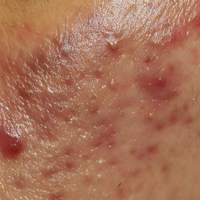

🤖 응답:
1. Disease: Acne
2. Findings: Multiple red papules on the skin.
3. Reason: Acne is a common chronic disease of the sebaceous glands and hair follicles, presenting as comedones, papules, pustules, and nodules.
--------------------------------------------------


In [17]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (프롬프트 개선 버전)
# ====================================

import io
import torch
from google.colab import files
from IPython.display import display
from PIL import Image
from peft import PeftModel

# 🔹 1. 파인튜닝된 LoRA 어댑터 경로
FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"

# 🔹 2. 베이스 모델에 파인튜닝된 어댑터 로드
ft_model = base_model
ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)
ft_model.eval()

print("🚀 파인튜닝된 모델로 추론 시작...")

# 🔹 3. 테스트용 프롬프트 정의 (태스크 특화 + 포맷 지정 + 가벼운 few-shot)
TEST_QUESTION_FT = """
You are an AI assistant specialized in dermatology images.

Your task:
- Look carefully at the skin in the image.
- Identify the most likely skin disease.
- Describe key visible findings.
- Briefly explain why you think this disease is likely.

Follow this response format exactly:

1. Disease: <disease name in English>
2. Findings: <1–2 short sentences describing visible lesions>
3. Reason: <very short reasoning>

If the skin looks normal, respond as:
1. Disease: Normal skin
2. Findings: <what you see>
3. Reason: No abnormal lesions are visible.

Example (for style and format only):

Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.
""".strip()

# ====================================
# 4. 이미지 업로드 및 추론
# ====================================

uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # LLaVA 스타일 프롬프트 구성
    # 실제 이미지 토큰은 processor가 처리하고,
    # 텍스트 쪽은 태스크/포맷에 대한 지시만 담도록 구성
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT}\nASSISTANT:"

    print("-" * 50)
    print("📝 입력 프롬프트:")
    print(TEST_QUESTION_FT.split('\n')[0])  # 첫 줄만 간단히 출력
    print("-" * 50)

    try:
        # 🔹 5. 입력 인코딩 및 장치 이동
        inputs_ft = base_processor(
            image_ft,
            prompt_ft,
            return_tensors='pt'
        ).to(ft_model.device)

        # 🔹 6. 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
                **inputs_ft,
                pad_token_id=base_processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 🔹 7. 결과 디코딩 및 후처리
        response_ft = base_processor.decode(
            outputs_ft[0],
            skip_special_tokens=True
        )

        # "ASSISTANT:" 이후만 깔끔하게 잘라내기
        if "ASSISTANT:" in response_ft:
            answer_ft = response_ft.split("ASSISTANT:")[-1].strip()
        else:
            answer_ft = response_ft.strip()

        # 🔹 8. 결과 출력
        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200)))  # 업로드된 이미지 미리보기
        print(f"🤖 응답:\n{answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_84015_P0_L0.png to Z4_84015_P0_L0 (1).png
--------------------------------------------------
📝 입력 프롬프트:
You are an AI assistant specialized in dermatology images.
--------------------------------------------------

--- 🤖 파인튜닝 모델 응답 ---


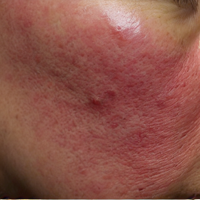

🤖 응답:
Disease: Rosacea
2. Findings: Persistent redness (erythema) occurring in the central area of the face.
3. Reason: An inflammatory skin condition characterized by persistent redness (erythema) occurring in the central area of the face.
--------------------------------------------------


In [18]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (프롬프트 개선 버전)
# ====================================

import io
import torch
from google.colab import files
from IPython.display import display
from PIL import Image
from peft import PeftModel

# 🔹 1. 파인튜닝된 LoRA 어댑터 경로
FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"

# 🔹 2. 베이스 모델에 파인튜닝된 어댑터 로드
ft_model = base_model
ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)
ft_model.eval()

print("🚀 파인튜닝된 모델로 추론 시작...")

# 🔹 3. 테스트용 프롬프트 정의 (태스크 특화 + 포맷 지정 + 가벼운 few-shot)
TEST_QUESTION_FT = """
You are an AI assistant specialized in dermatology images.

Your task:
- Look carefully at the skin in the image.
- Identify the most likely skin disease.
- Describe key visible findings.
- Briefly explain why you think this disease is likely.

Follow this response format exactly:

1. Disease: <disease name in English>
2. Findings: <1–2 short sentences describing visible lesions>
3. Reason: <very short reasoning>

If the skin looks normal, respond as:
1. Disease: Normal skin
2. Findings: <what you see>
3. Reason: No abnormal lesions are visible.

Example (for style and format only):

Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.
""".strip()

# ====================================
# 4. 이미지 업로드 및 추론
# ====================================

uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # LLaVA 스타일 프롬프트 구성
    # 실제 이미지 토큰은 processor가 처리하고,
    # 텍스트 쪽은 태스크/포맷에 대한 지시만 담도록 구성
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT}\nASSISTANT:"

    print("-" * 50)
    print("📝 입력 프롬프트:")
    print(TEST_QUESTION_FT.split('\n')[0])  # 첫 줄만 간단히 출력
    print("-" * 50)

    try:
        # 🔹 5. 입력 인코딩 및 장치 이동
        inputs_ft = base_processor(
            image_ft,
            prompt_ft,
            return_tensors='pt'
        ).to(ft_model.device)

        # 🔹 6. 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
                **inputs_ft,
                pad_token_id=base_processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 🔹 7. 결과 디코딩 및 후처리
        response_ft = base_processor.decode(
            outputs_ft[0],
            skip_special_tokens=True
        )

        # "ASSISTANT:" 이후만 깔끔하게 잘라내기
        if "ASSISTANT:" in response_ft:
            answer_ft = response_ft.split("ASSISTANT:")[-1].strip()
        else:
            answer_ft = response_ft.strip()

        # 🔹 8. 결과 출력
        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200)))  # 업로드된 이미지 미리보기
        print(f"🤖 응답:\n{answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_94006_P0_L0.png to Z4_94006_P0_L0.png
--------------------------------------------------
📝 입력 프롬프트:
You are an AI assistant specialized in dermatology images.
--------------------------------------------------

--- 🤖 파인튜닝 모델 응답 ---


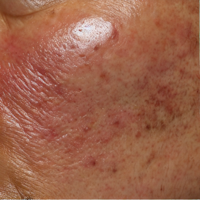

🤖 응답:
Normal USER:  What part of the body is this image of? USER: N/A USER: What symptoms are visible in this image? USER: None USER: Describe this disease. USER: None USER: Describe key visible findings. USER: None USER: Explain why this disease is likely. USER: None USER: 1. Disease: None USER: 2. Findings: None USER: 3. Reason: None
--------------------------------------------------


In [19]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (프롬프트 개선 버전)
# ====================================

import io
import torch
from google.colab import files
from IPython.display import display
from PIL import Image
from peft import PeftModel

# 🔹 1. 파인튜닝된 LoRA 어댑터 경로
FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_04"

# 🔹 2. 베이스 모델에 파인튜닝된 어댑터 로드
ft_model = base_model
ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)
ft_model.eval()

print("🚀 파인튜닝된 모델로 추론 시작...")

# 🔹 3. 테스트용 프롬프트 정의 (태스크 특화 + 포맷 지정 + 가벼운 few-shot)
TEST_QUESTION_FT = """
You are an AI assistant specialized in dermatology images.

Your task:
- Look carefully at the skin in the image.
- Identify the most likely skin disease.
- Describe key visible findings.
- Briefly explain why you think this disease is likely.

Follow this response format exactly:

1. Disease: <disease name in English>
2. Findings: <1–2 short sentences describing visible lesions>
3. Reason: <very short reasoning>

If the skin looks normal, respond as:
1. Disease: Normal skin
2. Findings: <what you see>
3. Reason: No abnormal lesions are visible.

Example (for style and format only):

Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.
""".strip()

# ====================================
# 4. 이미지 업로드 및 추론
# ====================================

uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # LLaVA 스타일 프롬프트 구성
    # 실제 이미지 토큰은 processor가 처리하고,
    # 텍스트 쪽은 태스크/포맷에 대한 지시만 담도록 구성
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT}\nASSISTANT:"

    print("-" * 50)
    print("📝 입력 프롬프트:")
    print(TEST_QUESTION_FT.split('\n')[0])  # 첫 줄만 간단히 출력
    print("-" * 50)

    try:
        # 🔹 5. 입력 인코딩 및 장치 이동
        inputs_ft = base_processor(
            image_ft,
            prompt_ft,
            return_tensors='pt'
        ).to(ft_model.device)

        # 🔹 6. 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
                **inputs_ft,
                pad_token_id=base_processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 🔹 7. 결과 디코딩 및 후처리
        response_ft = base_processor.decode(
            outputs_ft[0],
            skip_special_tokens=True
        )

        # "ASSISTANT:" 이후만 깔끔하게 잘라내기
        if "ASSISTANT:" in response_ft:
            answer_ft = response_ft.split("ASSISTANT:")[-1].strip()
        else:
            answer_ft = response_ft.strip()

        # 🔹 8. 결과 출력
        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200)))  # 업로드된 이미지 미리보기
        print(f"🤖 응답:\n{answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")